# setup

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
sys.path.append("/usr/local/Cellar/opencv3/3.2.0/lib/python3.5/site-packages/") # mac opencv path
import cv2
import numpy as np
from typing import Tuple, List, Text, Dict, Any, Iterator
import time


def mtx_plot(fnmtx, ratio):
    h = len(fnmtx[0])
    w = len(fnmtx)
    k = 1
    fig = plt.figure(figsize=(ratio[0]*h, ratio[1]*w))
    for fnarr in fnmtx:
        for fn in fnarr:
            fig.add_subplot(w,h,k)
            fn(k)
            k += 1

# input data

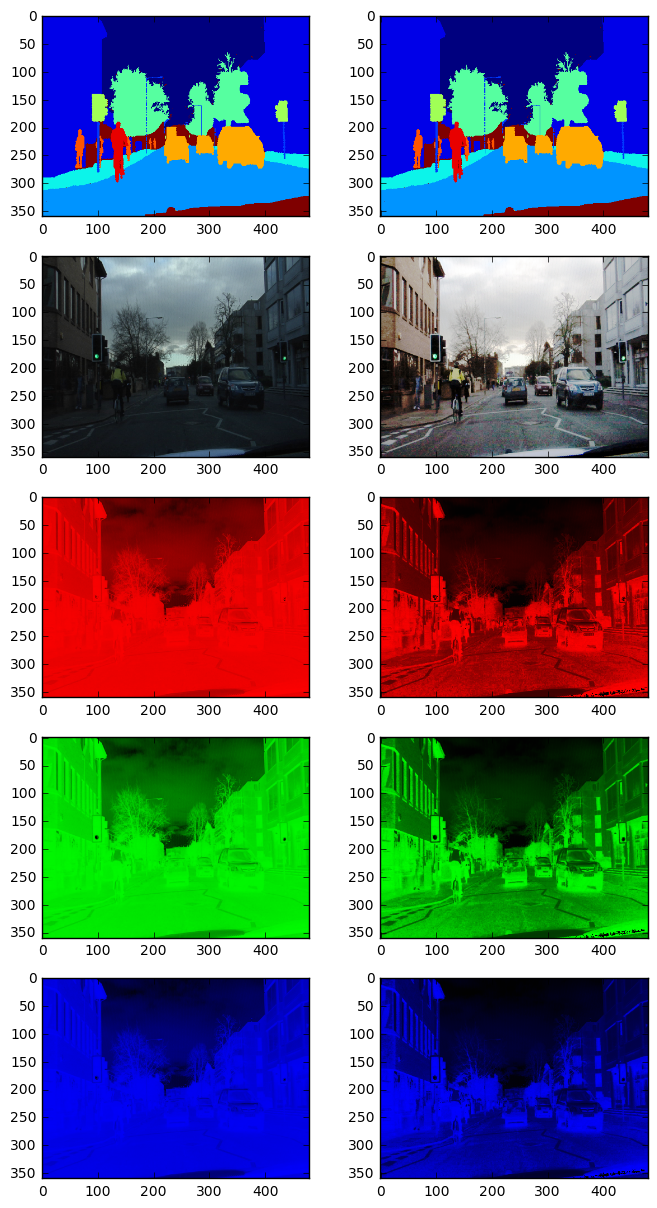

In [6]:
x = 'data/test/0001TP_008550.png'
y = 'data/testannot/0001TP_008550.png'
#x = 'data/train/0001TP_007140.png'
#y = 'data/trainannot/0001TP_007140.png'

img = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
norm = np.ones(img.shape, img.dtype)*255
norm[:,:,0] = cv2.equalizeHist(img[:,:,0])
norm[:,:,1] = cv2.equalizeHist(img[:,:,1])
norm[:,:,2] = cv2.equalizeHist(img[:,:,2])

mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
annot = np.zeros(mask.shape, np.uint8)
for i in range(12): annot[np.where(mask == i)] = 255/12*i

mat1 = [
    [
        lambda x: plt.imshow(mask),
        lambda x: plt.imshow(annot),
    ],
    [
        lambda x: plt.imshow(img),
        lambda x: plt.imshow(norm),
    ]
]

for ch in range(3):
    mat1.append([
        (lambda ch:
            (lambda x: exec('tmp = np.ones(norm.shape, np.int8)*255; tmp[:,:,%d] = img[:,:,%d]; plt.imshow(tmp)' % (ch, ch)))
        )(ch),
        (lambda ch:
            (lambda x: exec('tmp = np.ones(norm.shape, np.int8)*255; tmp[:,:,%d] = norm[:,:,%d]; plt.imshow(tmp)' % (ch, ch)))
        )(ch),
    ])

mtx_plot(mat1, ratio=(4,3))


# prediction

True
(1, 480, 360, 12) (480, 360, 12)
(360, 480, 12)
(360, 480)
[[4 4 4 ..., 2 2 2]
 [9 5 9 ..., 2 0 2]
 [9 5 9 ..., 2 4 4]
 ..., 
 [2 0 2 ..., 2 8 2]
 [2 2 2 ..., 2 7 2]
 [2 2 2 ..., 2 5 5]]
False
(1, 480, 360, 12) (480, 360, 12)
(360, 480, 12)
(360, 480)
[[ 1  1  1 ...,  1 11 11]
 [ 1  1  1 ...,  1  1  1]
 [ 1  1  1 ...,  1  1  1]
 ..., 
 [11  3  3 ...,  3  3 11]
 [11  3  3 ..., 11  3 11]
 [ 3  3  3 ..., 11 11 11]]


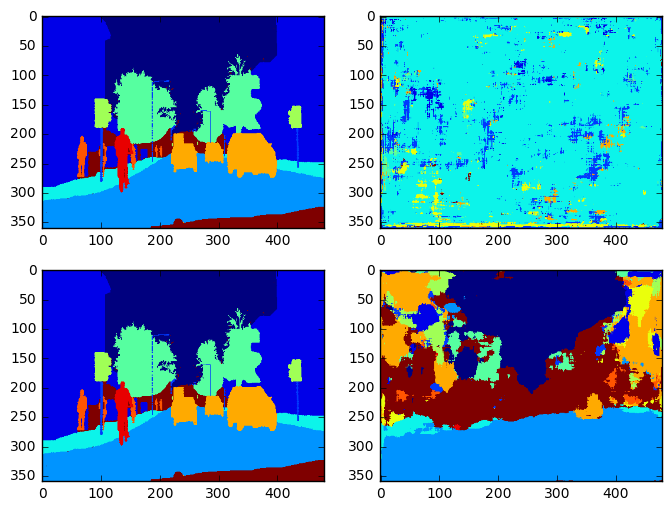

In [14]:

import tensorflow as tf

mat2 = []

with tf.device('/cpu:0'):
    from keras.models import model_from_json
    from SegNet import create_segnet
    
    for use_indices in [True, False]:
    
        if use_indices:
            print(use_indices)
            model = create_segnet(shape=(480, 360, 3), nb_class=12, indices=True)
            model.load_weights('2017-04-13-12-17-47_indices_weight.hdf5')
        else:
            print(use_indices)
            with open('2017-04-13-10-57-05_model.json', 'r') as f: model = model_from_json(f.read())
            model.load_weights('2017-04-13-10-57-05weights.12-0.47.hdf5')

        frame = np.expand_dims(np.einsum('hwc->whc', img), axis=0)
        output = model.predict(frame)

        print(output.shape, output[0].shape)
        output = np.einsum('whc->hwc', output[0])
        print(output.shape)
        output = np.argmax(output, axis=2)
        print(output.shape)
        print(output)

        _annot = np.zeros(annot.shape, np.uint8)
        for i in range(12): _annot[np.where(output == i)] = 255/12*i

        mat2.append([
            (lambda annot: lambda x: plt.imshow(annot))(annot),
            (lambda _annot: lambda x: plt.imshow(_annot))(_annot),
        ])


mtx_plot(mat2, ratio=(4,3))